In [25]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random
import w 
import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
d=5
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = [1]*5
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x1 = np.linspace(0, 20, n_points).reshape(n_points, 1)
x2=np.random.normal(0,1,n_points*4).reshape(n_points, 4)
x=np.column_stack([x1,x2])

f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x1, x1)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)+x2@np.array([0.3,-.4,1,-.9]).reshape(4, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs


In [26]:
y.shape

(200, 1)

(5.0, 25.0)

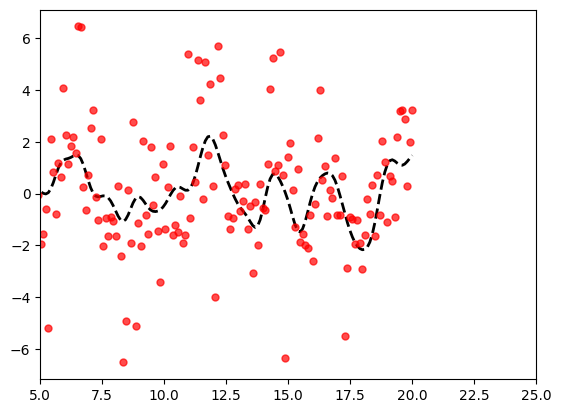

In [27]:

plt.plot(x[:,0], f, color='black', ls='--', lw=2)
plt.plot(x_obs[:,0], y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(5, 25)

In [28]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n ** 2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)

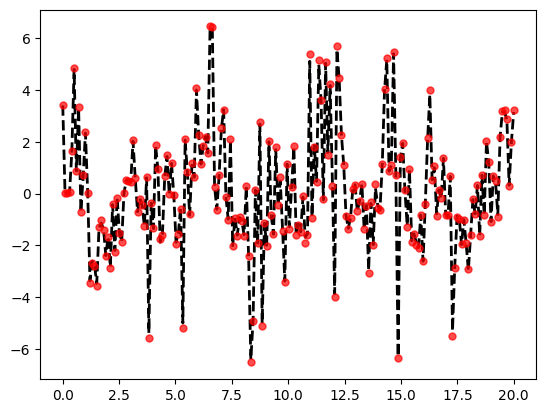

In [33]:
plt.plot(x[:,0], f_mean, color='black', ls='--', lw=2)
plt.plot(x_obs[:,0], y_obs, 'r.', ms=10, alpha=0.7)

In [34]:
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + 2 * J_w_inv / sigma_2)
    q2 = tf.matmul((2 * J_w_inv / sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)


def update_Sigma_f(c_f, K, sigma_2, J_w):
    """
    Compute the updated value of Sigma_f.

    Parameters:
        c_f (float): Scaling constant.
        K (Tensor): Kernel matrix.
        sigma_2 (float): Noise variance.
        J_w (Tensor): Weight matrix.

    Returns:
        Tensor: The updated value of Sigma_f.
    """
    Sigma_f = c_f * K * tf.linalg.inv(K + sigma_2 * J_w / 2) * sigma_2 * J_w / 2
    return Sigma_f


def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    #update quantitites, Sigma_a,J_w
    w_full = sigma / (2 ** 0.5) * w_full
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2))) * sigma ** 2 / 2
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2))) * 2 / (sigma ** 2)

    Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

    Sigma_a = alpha * K + (1 - alpha) * Sigma_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a)

    mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full)
    return (mu_f, Sigma_f)



import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2
@tf.function
def add_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood_variance) -> tf.Tensor:
    k_diag = tf.linalg.diag_part(K)
    return tf.linalg.set_diag(K, k_diag + likelihood_variance * (W ** -2))


@tf.function
def loo_cv(X, y, mean_function, kernel, W, noise_variance, likelihood) -> tf.Tensor:
    r"""
    Computes the leave one out to train the model
    """
    err = y - tf.reshape(mean_function(X), (-1, 1))
    K = kernel.matrix(X, X)
    n = tf.cast(tf.shape(X)[0], K.dtype)

    likelihood_variance = likelihood.variance_at(X)  #####WHAT IS THIS???
    W = w.IMQ(c)

    W, W_dy = W.w_dy(X, err)
    dylog2 = 2 * likelihood_variance * W_dy / W
    Y_bar = err - dylog2

    K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
    L_sW = tf.linalg.cholesky(K_sW)
    L_sW_inv = tf.linalg.inv(L_sW)

    #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

    #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
    diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv ** 2, axis=0), (-1, 1))

    A = diag_K_sW_inv * dylog2

    #B = tf.matmul(K_sW_inv, Y_bar)
    B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
    C = diag_K_sW_inv * (1 - diag_K_sW_inv * (likelihood_variance * (W ** -2) - likelihood_variance))

    D = C / diag_K_sW_inv ** 2

    loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
    loo -= 0.5 * n * np.log(2 * np.pi)
    loo -= 0.5 * tf.reduce_sum((A + B) ** 2 / C)
    return loo


sigma = tf.Variable(0.1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


import tensorflow_probability as tfp

for i in range(500):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)

        new_ind = list(train_indices.numpy())
        #update quantitites, Sigma_a,J_w
        w_train = tf.gather(w_full, train_indices)
        m_w = tf.gather(m_w_full, train_indices)
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

        Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

        Sigma_a = alpha * K + (1 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a)

        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w)
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K) @ mu_f
        sigma_f_pred = K_star_star
        sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K + sigma ** 2 * J_w) @ K_star
        sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K) @ K_star + tf.linalg.eye(
            n_test, dtype=tf.float64) * sigma**2
        sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)#*tf.gather(w_full, test_indices)**(-2)
        vv = tfp.distributions.Normal(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(Y_test)

        """
        Computes the leave one out to train the model
        """

        """
             err = y -tf.reshape(mean_function(X), (-1, 1))
        K = kernel.matrix(X,X)
        n = tf.cast(tf.shape(X)[0], K.dtype)
        
        likelihood_variance = likelihood.variance_at(X) #####WHAT IS THIS???
        W=IMQ(c)
        W,W_dy=W.w_dy(X,err)
        dylog2 = 2*likelihood_variance*W_dy/W
        Y_bar = err - dylog2
        
        K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
        L_sW = tf.linalg.cholesky(K_sW)
        L_sW_inv = tf.linalg.inv(L_sW)

        #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

        #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
        diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv**2, axis=0), (-1, 1))

        A = diag_K_sW_inv*dylog2
        
        #B = tf.matmul(K_sW_inv, Y_bar)
        B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
        C = diag_K_sW_inv * (1-diag_K_sW_inv*(likelihood_variance*(W**-2) - likelihood_variance))

        D = C/diag_K_sW_inv**2

        loss = - 0.5 * tf.reduce_sum(tf.math.log(D))
        loss -= 0.5 * n * np.log(2 * np.pi)
        loss -= 0.5 * tf.reduce_sum((A+B)**2/C)
        
        """
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))

Mu_full, Sigma_full1 = Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

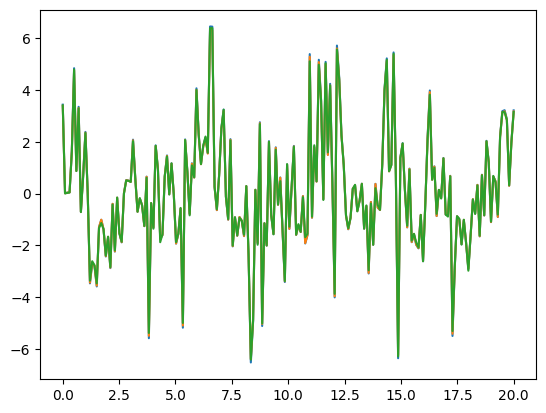

In [35]:
plt.plot(x[:,0],y)
plt.plot(x[:,0],Mu_full)
plt.plot(x[:,0],f_mean)

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.599996635316742>